In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
from scipy.io import wavfile
from scipy.interpolate import interp1d
from scipy.signal import spectrogram, istft
import pywt
from pywt import wavedec, waverec

We read the image and we threshold it

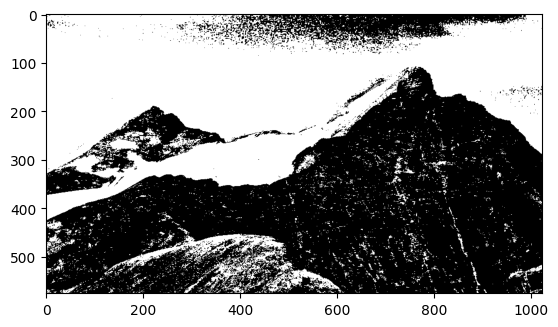

In [3]:
image = cv2.imread('../data/input_images/grande_sassiere.jpg')
imgray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(imgray, 90, 255, 0)
plt.imshow(thresh, cmap='gray')


### algo to detect the longest shape from a contour detection

We retrieve all the contours of the image

In [4]:
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

then we extract the longest contour in a np array

In [5]:
cnt_index = np.argmax(np.array([len(c) for c in contours]))
cnt = contours[cnt_index]
cnt = np.squeeze(cnt)

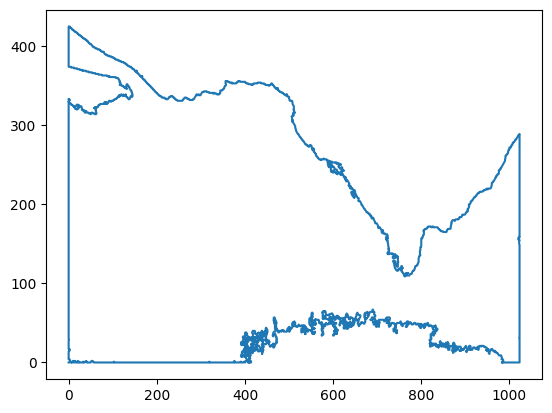

In [6]:
plt.plot(cnt[:, 0], cnt[:, 1])
plt.show()

The problem is that the longest contour is a closed shape which takes the bordures of the image and other artifacts. We would like to be able to isolate only the top contour to obtain an injective function. To do this I have built a small algo to identify continuous shapes starting from some x coordinate in the previously identified shape:
- we should find the top and bottom contour and some intermediate artifacts
- finding the top contour from this should be easy

In [7]:
# shape dict will contain all the injective function which will correspond to a contour
shape_dict = {}

def point_hasher(point):
    return str(point[0]) + str(point[1])

# init

# we find all the points at the minimum abscisse on the image, each of this point
# is the potential begining of a contour shape

init_points = cnt[cnt[:, 0] == np.min(cnt[:, 0])]

for point in init_points:
    shape_dict[point_hasher(point)] = [point]

# iteration 

for x in range(2, image.shape[1]):
    # we find the points on the abscisse x
    temp_points = cnt[cnt[:, 0] == x]
    running_dict = shape_dict.copy()

    # the following loop goes through the existing shapes (contours) in the shape dict
    # the goal is to associate points in temp_points to one of the existing shapes
    treated_points_index = -1

    for k in shape_dict.keys():

        # this condition insure that if a point has aloready associated to a shape it gets deleted from temp_points
        if treated_points_index != -1:
            temp_points = np.delete(temp_points, treated_points_index, axis=0)

        # if there are no points we stop the loop
        if len(temp_points) == 0:
            break
        
        # we then calculate for one given shape the last point of the shape (the one of highest abscisse)
        # its distance to all the points in temp_points
        previous_point = shape_dict[k][-1]

        temp_distances = []
        for point in temp_points:
            temp_distances.append(np.linalg.norm(previous_point - point))
        
        # if the closest point to the end point of the shape is closer than some radius (here 10px) we consider that it is
        # part of the shape and we add it so that it becomes the new end point of the shape
        if min(temp_distances) < 10:

            index_closest_temp_point = temp_distances.index(min(temp_distances))
            treated_points_index = index_closest_temp_point

            running_dict[k].append(temp_points[index_closest_temp_point])

        # if there are no points in the neighborhood of the end point of the shape we are treating
        # the no point gets deleted of temp_points
        else:
            treated_points_index = -1

    # the leftover points which are the points which we could associate to no shape
    # could potentially be the beginning of new shape, so we add them to the shape_dict as such
    for point in temp_points:
        running_dict[point_hasher(point)] = [point]
            
    

    shape_dict = running_dict.copy()

        
    

We identify the longest shape that we were able to calculate

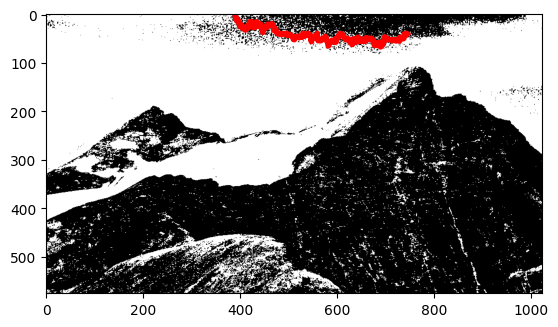

In [8]:
sorted_keys = sorted(shape_dict.keys(), key=lambda key: len(shape_dict[key]))

cnt = np.array(shape_dict[sorted_keys[-1]])
mplt_image = cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB)

plt.plot(cnt[:, 0], cnt[:, 1], color='red', linewidth=4)
plt.imshow(mplt_image)
plt.show()

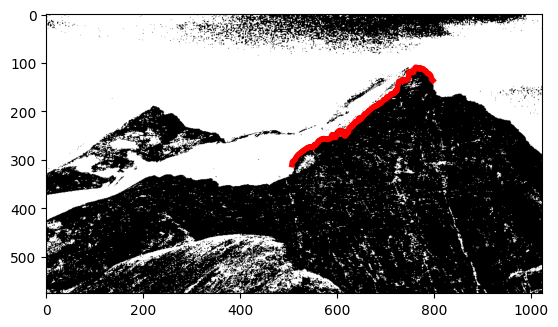

In [9]:
sorted_keys = sorted(shape_dict.keys(), key=lambda key: len(shape_dict[key]))

cnt = np.array(shape_dict[sorted_keys[-2]])
mplt_image = cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB)

plt.plot(cnt[:, 0], cnt[:, 1], color='red', linewidth=4)
plt.imshow(mplt_image)
plt.show()

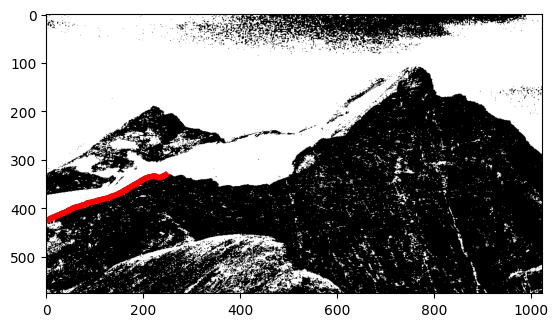

In [10]:
sorted_keys = sorted(shape_dict.keys(), key=lambda key: len(shape_dict[key]))

cnt = np.array(shape_dict[sorted_keys[-3]])
mplt_image = cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB)

plt.plot(cnt[:, 0], cnt[:, 1], color='red', linewidth=4)
plt.imshow(mplt_image)
plt.show()

This method does not seem to work as intented, it identifies very short line and not the full contour.

### Algo to detect the shape from an edge detection

We try making edge detection on the image after it was treated by a canny filter.

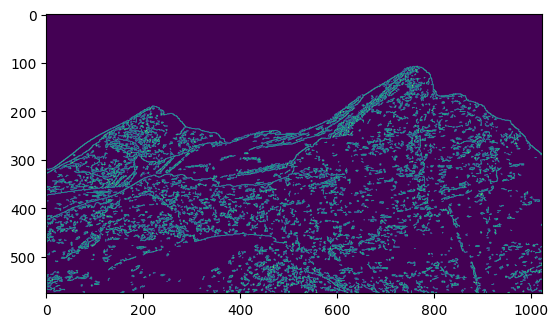

In [11]:
edges = cv2.Canny(image, threshold1=100, threshold2=150)
plt.imshow(edges)


We get an image with a very clear boundary between the sky and the mountain, there is absolutly no noise or ambiguity to distinguish the two. For this reason we can isolate the shape just by looking for the first non negative pixel value for each x coordinate.

In [12]:
shape = []
for i in range(image.shape[1]):
    for j in range(image.shape[0]):
        if edges[j, i] > 0:
            shape.append(np.array([i, j], dtype=np.int32))
            break
        
shape = np.array(shape)


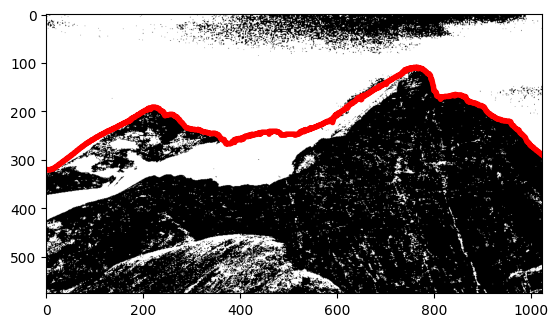

In [13]:
mplt_image = cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB)

plt.plot(shape[:, 0], shape[:, 1], color='red', linewidth=4)
plt.imshow(mplt_image)
plt.show()

this method works perfectly